In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    r2_score
)
import xgboost as xgb

# ===============================
# 1) LOAD DATA
# ===============================
df = pd.read_parquet("../data_backend/cleaned_data_2.parquet")

target_col = "ffb_1%_oer"

raw_features = [
    "import", "export", "production", "end_stock", 
    "cpo_futures", "usd_myr_rate", "brent_oil_futures", 
    "soybean_futures", "precipitation", "avg_temperature", "avg_humidity"
]

engineered_features = [
    "lag_1","lag_3","lag_7","rolling_mean_7",
    "rolling_mean_30","rolling_std_7","rolling_std_30",
    "pct_change_1","pct_change_7"
]

# XGBoost uses engineered features only
X_full = df[engineered_features].values
y_full = df[target_col].values.reshape(-1, 1)

# ===============================
# 2) SPLIT TRAIN / VAL / TEST
# ===============================
N = len(df)
train_size = int(N * 0.7)
val_size   = int(N * 0.2)
test_size  = N - train_size - val_size

X_train_raw = X_full[:train_size]
X_val_raw   = X_full[train_size:train_size + val_size]
X_test_raw  = X_full[train_size + val_size:]

y_train_raw = y_full[:train_size]
y_val_raw   = y_full[train_size:train_size + val_size]
y_test_raw  = y_full[train_size + val_size:]


# ===============================
# 3) SCALING
# ===============================
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(X_train_raw)
X_val   = scaler_x.transform(X_val_raw)
X_test  = scaler_x.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw)
y_val   = scaler_y.transform(y_val_raw)
y_test  = scaler_y.transform(y_test_raw)


# ===============================
# 4) MULTI-STEP CONFIG
# ===============================
forecast_horizon = 14
lookback = 90

# Use engineered features only
X_train_xgb = X_train
X_val_xgb   = X_val
X_test_xgb  = X_test


# ===============================
# 5) XGBOOST PARAMS
# ===============================
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "min_child_weight": 3,
    "gamma": 0,
    "lambda": 1,
    "alpha": 0,
    "seed": 42
}

xgb_models = []
y_preds = []


# ===============================
# 6) TRAIN MODELS FOR EACH STEP
# ===============================
for step in range(forecast_horizon):

    # Slice y per-horizon
    y_train_step = y_train[lookback + step : len(y_train) - forecast_horizon + step + 1]
    y_val_step   = y_val[lookback + step : len(y_val) - forecast_horizon + step + 1]
    y_test_step  = y_test[lookback + step : len(y_test) - forecast_horizon + step + 1]

    # Slice matching X
    X_train_step = X_train_xgb[lookback : lookback + len(y_train_step)]
    X_val_step   = X_val_xgb[lookback   : lookback + len(y_val_step)]
    X_test_step  = X_test_xgb[lookback  : lookback + len(y_test_step)]

    dtrain = xgb.DMatrix(X_train_step, label=y_train_step)
    dval   = xgb.DMatrix(X_val_step, label=y_val_step)
    dtest  = xgb.DMatrix(X_test_step)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    xgb_models.append(model)
    y_preds.append(model.predict(dtest))

# shape → (num_samples, horizon)
y_pred_norm = np.column_stack(y_preds)

# Undo scaling
y_pred = scaler_y.inverse_transform(y_pred_norm)


# ===============================
# 7) TRUE FUTURE MATRICES
# ===============================
y_true_inv = scaler_y.inverse_transform(y_test)

y_true_multi = []
for step in range(forecast_horizon):
    y_true_multi.append(
        y_true_inv[lookback + step : len(y_true_inv) - forecast_horizon + step + 1, 0]
    )

y_true_multi = np.column_stack(y_true_multi)


# ===============================
# 8) STEP-WISE METRICS
# ===============================
print("=== Step-wise Evaluation ===")
rmse_list, mae_list, r2_list = [], [], []

for step in range(forecast_horizon):
    y_t = y_true_multi[:, step]
    y_p = y_pred[:, step]

    rmse = root_mean_squared_error(y_t, y_p)
    mae  = mean_absolute_error(y_t, y_p)
    r2   = r2_score(y_t, y_p)

    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

    print(f"Step {step+1:02d}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# Optional → put into DF
results_df = pd.DataFrame({
    "step": np.arange(1, forecast_horizon + 1),
    "RMSE": rmse_list,
    "MAE": mae_list,
    "R2":  r2_list
})

results_df


=== Step-wise Evaluation ===
Step 01: RMSE=0.3185, MAE=0.2586, R²=0.9915
Step 02: RMSE=0.7542, MAE=0.6081, R²=0.9533
Step 03: RMSE=1.1291, MAE=0.8900, R²=0.8976
Step 04: RMSE=1.4152, MAE=1.1509, R²=0.8428
Step 05: RMSE=1.6930, MAE=1.4216, R²=0.7793
Step 06: RMSE=1.6910, MAE=1.3950, R²=0.7837
Step 07: RMSE=2.2380, MAE=1.9148, R²=0.6277
Step 08: RMSE=2.7148, MAE=2.3268, R²=0.4633
Step 09: RMSE=2.7527, MAE=2.3443, R²=0.4622
Step 10: RMSE=2.8624, MAE=2.3774, R²=0.4346
Step 11: RMSE=3.1081, MAE=2.5756, R²=0.3487
Step 12: RMSE=3.0993, MAE=2.4999, R²=0.3640
Step 13: RMSE=3.0736, MAE=2.4615, R²=0.3868
Step 14: RMSE=3.0019, MAE=2.4689, R²=0.4261


,step,RMSE,MAE,R2
0,1,0.318546,0.258622,0.991451
1,2,0.754205,0.608112,0.953257
2,3,1.129076,0.889959,0.897601
3,4,1.415156,1.150944,0.842791
4,5,1.693049,1.421630,0.779282
5,6,1.690964,1.394990,0.783720
6,7,2.238013,1.914822,0.627694
7,8,2.714840,2.326796,0.463339
8,9,2.752696,2.344336,0.462222
9,10,2.862387,2.377415,0.434625


In [9]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Flatten across all horizons & samples
y_true_flat = y_true_multi.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

rmse_overall = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
mse_overall  = mean_squared_error(y_true_flat, y_pred_flat)
r2_overall   = r2_score(y_true_flat, y_pred_flat)

print("\n=== OVERALL MULTI-STEP PERFORMANCE ===")
print(f"Overall RMSE: {rmse_overall:.4f}")
print(f"Overall MSE : {mse_overall:.4f}")
print(f"Overall R²  : {r2_overall:.4f}")



=== OVERALL MULTI-STEP PERFORMANCE ===
Overall RMSE: 2.3230
Overall MSE : 5.3963
Overall R²  : 0.6094


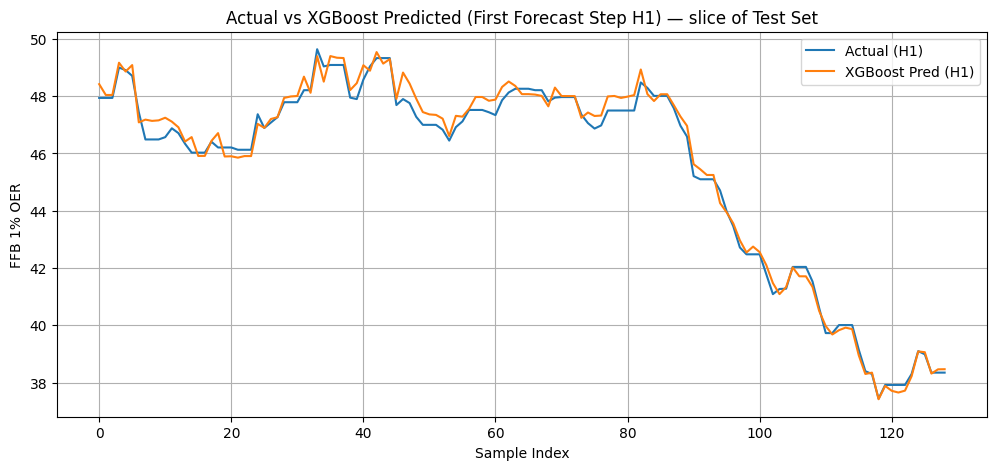

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
n_plot = min(230, y_true_multi.shape[0])  # plot first up to 230 samples

# Plot for the first forecast horizon (H1)
plt.plot(y_true_multi[:n_plot, 0].flatten(), label="Actual (H1)")#, color="blue", linewidth=2)
plt.plot(y_pred[:n_plot, 0].flatten(), label="XGBoost Pred (H1)")#, color="red", linestyle="--")

plt.title("Actual vs XGBoost Predicted (First Forecast Step H1) — slice of Test Set")
plt.xlabel("Sample Index")
plt.ylabel("FFB 1% OER")
plt.legend()
plt.grid(True)
plt.show()

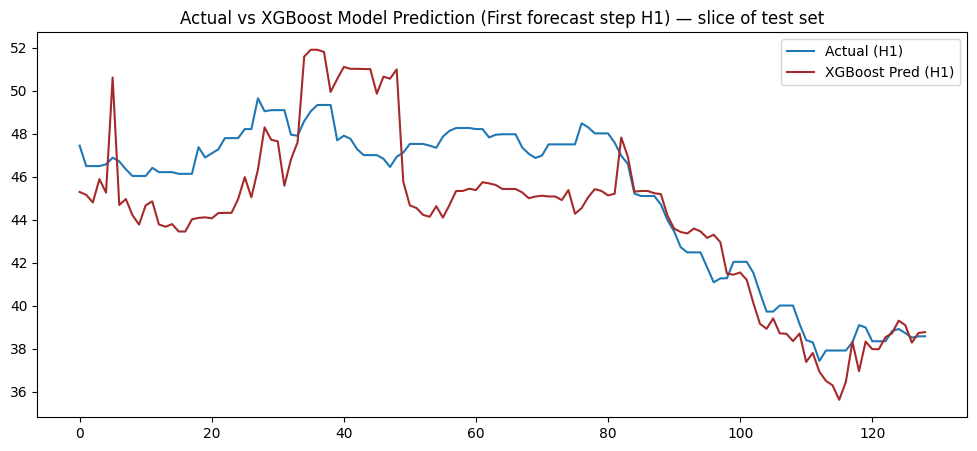

In [18]:
plt.figure(figsize=(12,5))
n_plot = min(230, y_true_multi.shape[0])  # plot first up to 230 samples

# Plot for the first forecast horizon (H1)
plt.plot(y_true_multi[:n_plot, 6].flatten(), label="Actual (H1)")#, color="blue", linewidth=2)
plt.plot(y_pred[:n_plot, 6].flatten(), label="XGBoost Pred (H1)",color="brown")#, color="red", linestyle="--")
plt.title("Actual vs XGBoost Model Prediction (First forecast step H1) — slice of test set")
plt.legend()
plt.show()

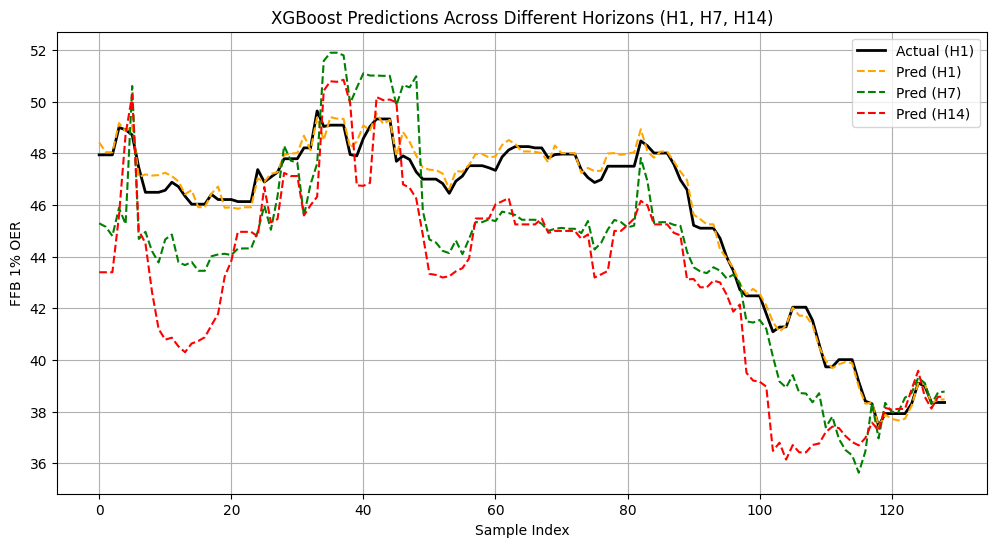

In [11]:
plt.figure(figsize=(12, 6))
n_plot = min(230, y_true_multi.shape[0])

plt.plot(y_true_multi[:n_plot, 0], label="Actual (H1)", color="black", linewidth=2)
plt.plot(y_pred[:n_plot, 0], label="Pred (H1)", color="orange", linestyle="--")
plt.plot(y_pred[:n_plot, 6], label="Pred (H7)", color="green", linestyle="--")
plt.plot(y_pred[:n_plot, 13], label="Pred (H14)", color="red", linestyle="--")

plt.title("XGBoost Predictions Across Different Horizons (H1, H7, H14)")
plt.xlabel("Sample Index")
plt.ylabel("FFB 1% OER")
plt.legend()
plt.grid(True)
plt.show()


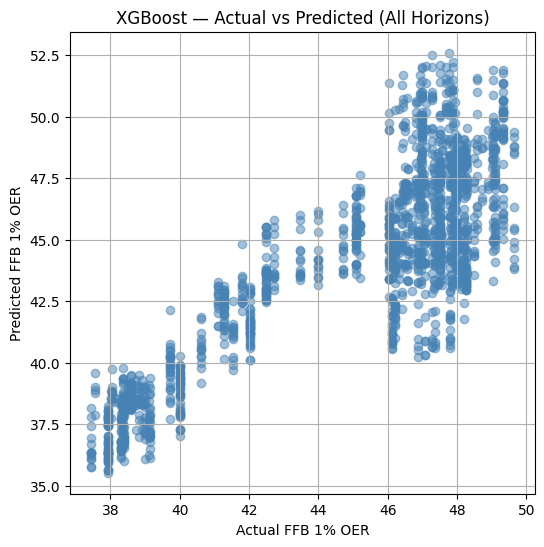

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(y_true_multi.flatten(), y_pred.flatten(), alpha=0.5, color="steelblue")
plt.xlabel("Actual FFB 1% OER")
plt.ylabel("Predicted FFB 1% OER")
plt.title("XGBoost — Actual vs Predicted (All Horizons)")
plt.grid(True)
plt.show()


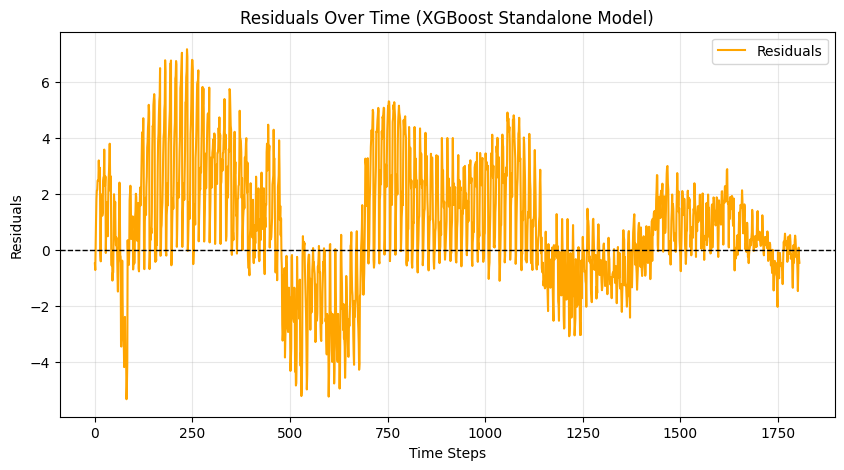

In [21]:
residuals = y_true_flat - y_pred_flat
plt.figure(figsize=(10,5))
plt.plot(residuals, color='orange', label="Residuals")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Residuals Over Time (XGBoost Standalone Model)")
plt.xlabel("Time Steps")
plt.ylabel("Residuals")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

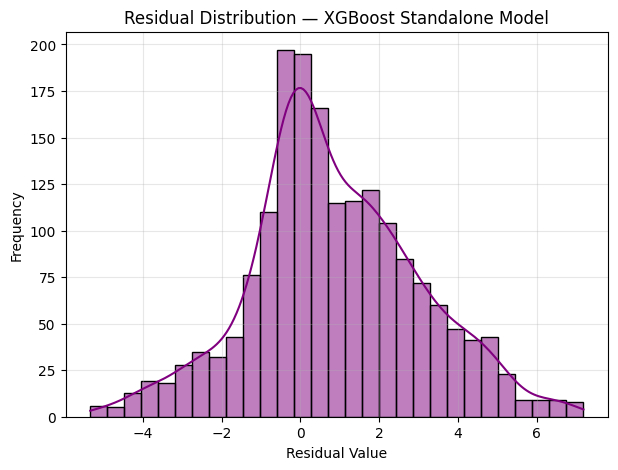

In [22]:
import seaborn as sns

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Residual Distribution — XGBoost Standalone Model")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [23]:
import numpy as np
import pandas as pd

features = raw_features + engineered_features

all_importances = []

for model in xgb_models:
    imp = model.get_score(importance_type='gain')
    row = {f: imp.get(f'f{i}', 0) for i, f in enumerate(features)}
    all_importances.append(row)

df_importance = pd.DataFrame(all_importances)
avg_importance = df_importance.mean().sort_values(ascending=False)


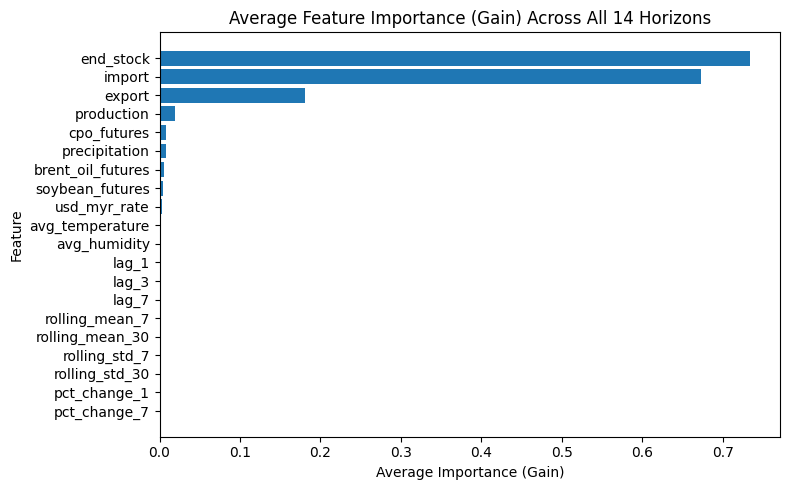

In [24]:
plt.figure(figsize=(8,5))
plt.barh(avg_importance.index, avg_importance.values)
plt.title("Average Feature Importance (Gain) Across All 14 Horizons")
plt.xlabel("Average Importance (Gain)")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
